# Chapter 7: Semi-Supervised GAN

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
# from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## Dataset

In [4]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [5]:
# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 100

dataset = Dataset(num_labeled)

# Semi-Supervied GAN

In [6]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## Generator

In [7]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

## Discriminator

In [8]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

In [9]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [10]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## Build the Model

In [11]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

### Discriminator

In [12]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer='adam')

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer='adam')

### Generator

In [13]:
# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer='adam')

## Training

In [14]:
supervised_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)

        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(
            imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

## Train the Model and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

In [15]:
# Set hyperparameters
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 0.001003]
1600 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000421]
2400 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000177]
3200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000036]
4000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000020]
4800 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000013]
5600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000004]
6400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000002]
7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000006]
8000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000002]


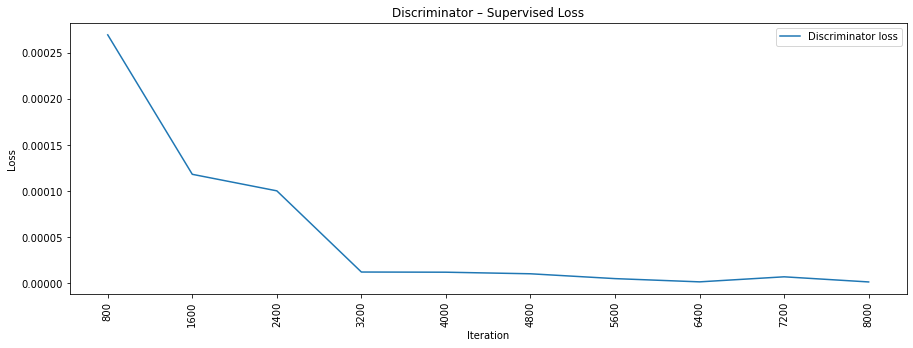

In [16]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## SGAN Classifier – Training and Test Accuracy 

In [17]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 4ms/step - loss: 1.6668e-04 - accuracy: 1.0000
Training Accuracy: 100.00%


In [18]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 2.4348 - accuracy: 0.6580
Test Accuracy: 65.80%


---

# Fully-Supervised Classifier

In [19]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer='adam')

In [21]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 2/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 3/30
4/4 [==============================] - 0s 9ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - 0s 9ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 0s 9ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 6/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 8/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 9/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 10/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 11/30
4/4 [======================

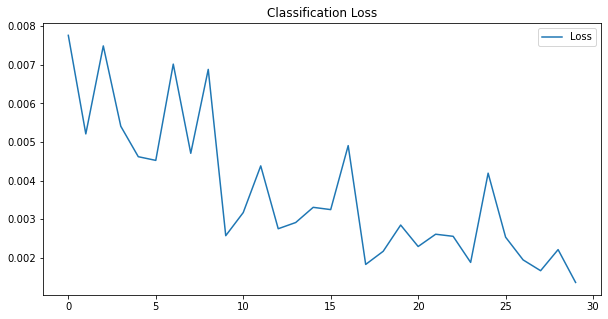

In [22]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

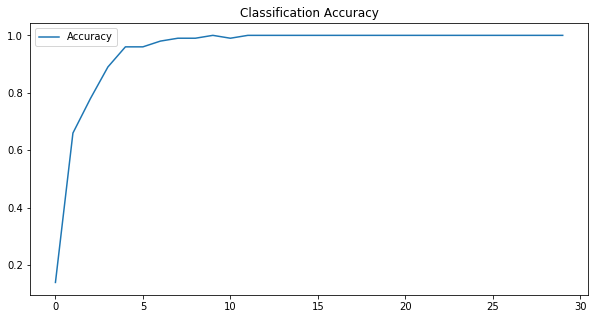

In [ ]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [23]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 4ms/step - loss: 0.8570 - accuracy: 1.0000
Training Accuracy: 100.00%


In [24]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 1.5711 - accuracy: 0.5978
Test Accuracy: 59.78%


---